In [116]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import duckdb
import os
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder
from torch_geometric.data import Dataset, Data
import deepchem as dc
from deepchem.feat.graph_data import GraphData
import torch
import os.path as osp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear, ReLU, Dropout, Softmax

In [37]:
print(os.getcwd())

/home/louis/Documents/personal_coding/graph_neural_networks/BELKA_project


In [38]:
def list_top_level_folders_and_files_directory(directory):
    with os.scandir(directory) as entries:
        for entry in entries:
            # if entry.is_dir():
                print(entry.name)

In [39]:
list_top_level_folders_and_files_directory(os.getcwd())


leash-tutorial-ecfps-and-random-forest.ipynb
.ipynb_checkpoints
submission.csv
data
belka_exploration.ipynb
.git


In [40]:
train_path = 'data/train.parquet'
test_path = 'data/test.parquet'

In [41]:
# 

'''
con = duckdb.connect()

df_temp = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT 5000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT 5000)""").df()

con.close()

df_temp

'''

'\ncon = duckdb.connect()\n\ndf_temp = con.query(f"""(SELECT *\n                        FROM parquet_scan(\'{train_path}\')\n                        WHERE binds = 0\n                        ORDER BY random()\n                        LIMIT 5000)\n                        UNION ALL\n                        (SELECT *\n                        FROM parquet_scan(\'{train_path}\')\n                        WHERE binds = 1\n                        ORDER BY random()\n                        LIMIT 5000)""").df()\n\ncon.close()\n\ndf_temp\n\n'

In [42]:
# df_temp.to_pickle("data/data_10000.pkl")

In [46]:
# df = pd.read_pickle("data/data_10000.pkl")

In [65]:
"""
one_hot = pd.get_dummies(df['protein_name'])
df = df.drop('protein_name',axis = 1)
df = df.join(one_hot)
"""

"\none_hot = pd.get_dummies(df['protein_name'])\ndf = df.drop('protein_name',axis = 1)\ndf = df.join(one_hot)\n"

In [75]:
# df.to_pickle("data/raw/data_10000_one_hot.pkl")

In [68]:
df = pd.read_pickle("data/data_10000_one_hot.pkl")

In [69]:
df

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,binds,BRD4,HSA,sEH
0,129306180,O=C(N[C@H]1C=C[C@@H](C(=O)O)C1)OCC1c2ccccc2-c2...,NCC1CCC(F)(F)CC1,Cl.NCC1(OCCO)CCS(=O)(=O)C1,O=C(N[Dy])[C@@H]1C=C[C@H](Nc2nc(NCC3CCC(F)(F)C...,0,1,0,0
1,84784412,O=C(NCc1cccc(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,Nc1ccc(Cl)nc1Cl,Cc1cc2cc(CN)ccc2[nH]1,Cc1cc2cc(CNc3nc(NCc4cccc(C(=O)N[Dy])c4)nc(Nc4c...,0,0,0,1
2,6342891,C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,Nc1ccc(Cl)c(F)c1,Cl.NCC1CCC2(CCC2)CO1,C=CCC(CC=C)(Nc1nc(NCC2CCC3(CCC3)CO2)nc(Nc2ccc(...,0,1,0,0
3,69078061,N#Cc1ccc([C@H](CC(=O)O)NC(=O)OCC2c3ccccc3-c3cc...,Cc1ncccc1N,Br.Br.NCC1CCCN1c1cccnn1,Cc1ncccc1Nc1nc(NCC2CCCN2c2cccnn2)nc(N[C@@H](CC...,0,0,1,0
4,285100560,O=C(O)[C@@H]1Cc2ccc(O)cc2CN1C(=O)OCC1c2ccccc2-...,NCC12CC=CC(C1)OC2,Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1,O=C(N[Dy])[C@@H]1Cc2ccc(O)cc2CN1c1nc(NCC23CC=C...,0,1,0,0
...,...,...,...,...,...,...,...,...,...
9995,27993,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,CC(C)(C#N)c1ccc(N)cc1,CCC(CN)Oc1ccccc1C.Cl,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCC(CC)Oc2ccccc2C...,1,1,0,0
9996,260421824,O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...,CC(C)(CN)CCC#N,Cl.Cl.NCc1ccncc1C(F)(F)F,CC(C)(CCC#N)CNc1nc(NCc2ccncc2C(F)(F)F)nc(N[C@H...,1,0,0,1
9997,97650610,O=C(N[C@@H](Cc1ccc(F)c(F)c1)C(=O)O)OCC1c2ccccc...,Cn1cncc1C(CN)N1CCCC1,Cl.NCc1nnc2ncccn12,Cn1cncc1C(CNc1nc(NCc2nnc3ncccn23)nc(N[C@@H](Cc...,1,0,1,0
9998,16603786,CC(C)(C)OCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,COc1ccc(Cl)c(N)c1.Cl,COc1ccc2nc(N)sc2c1,COc1ccc(Cl)c(Nc2nc(Nc3nc4ccc(OC)cc4s3)nc(NC(CO...,1,0,1,0


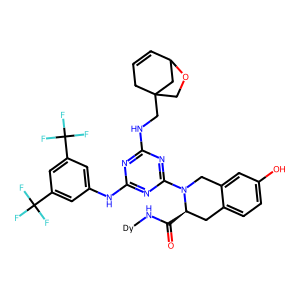

In [56]:
# Visualise one of the molecules from its SMILE input
inhibitor = df["molecule_smiles"][4]

m = rdkit.Chem.MolFromSmiles(inhibitor)

img = rdkit.Chem.Draw.MolToImage(m)

display(img)

In [86]:
# Custom torch geometric Dataset class to store the samples and their corresponding labels

class MoleculeDataset(Dataset):
  def __init__(self, root, pkl_file, transform=None, pre_transform=None, pre_filter=None):
    """
    root = Where the dataset should be stored. This folder is split
    into raw_dir (downloaded dataset) and processed_dir(processed data).
    """
    self.pkl_file = pkl_file
    super().__init__(root, transform, pre_transform, pre_filter)

  @property
  def raw_file_names(self):
    """
    If this file exists in raw_dir, the download is not triggered/
    (the download function is not implemented here)
    """
    return self.pkl_file

  @property
  def processed_file_names(self):
    """
    If these files are found in raw_dir, processing is skipped
    """
    self.data = pd.read_pickle(self.raw_paths[0]).reset_index()

    return [f'data_{i}.pt' for i in list(self.data.index)]

  def download(self):
    """
    No need to download the pkl file as it is already downloaded
    """
    pass

  def process(self):
    """
    I used Deepchem's MolGraphConvFeaturizer to create a graph and then convert that to a torch graph with to_pyg_graph.
    """
    self.data = pd.read_pickle(self.raw_paths[0]).reset_index()
    featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)

    for idx, row in self.data.iterrows():
      # Featurize molecule and convert to torch graph
      id = row['id']
      smiles = row['molecule_smiles']
      BRD4 = row['BRD4']
      HSA = row['HSA']
      sEH = row['sEH']  
      binds = row['binds']  

      out = featurizer.featurize(smiles)
      pyg_out = GraphData.to_pyg_graph(out[0])
      pyg_out.id = id
      pyg_out.smiles = smiles
      pyg_out.BRD4 = BRD4
      pyg_out.HSA = HSA
      pyg_out.sEH = sEH
      pyg_out.binds = binds

      # data = Data(x=pyg_out.x, edge_index=pyg_out.edge_index, edge_attr=pyg_out.edge_attr,
      #            y=torch.tensor([label]), dtype = torch.float)

      torch.save(pyg_out, osp.join(self.processed_dir, f'data_{idx}.pt'))

  def len(self):
    """
    Returns number of samples in the dataset
    """
    return len(self.processed_file_names)

  def get(self, idx):
    """
    Loads a single graph
    """
    data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
    return data

In [98]:
original_dataset = MoleculeDataset(root = "data/", pkl_file = "data_10000_one_hot.pkl").shuffle()
dataset = original_dataset

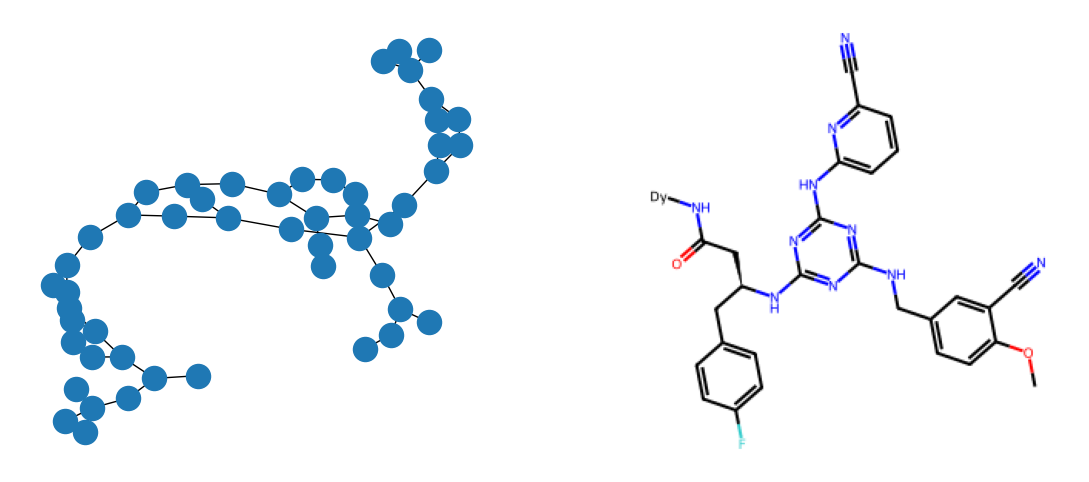

In [105]:
np.random.seed(44)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (14,6))

g = torch_geometric.utils.to_networkx(original_dataset[2], to_undirected=True)
nx.draw(g, ax = ax[0])

mol = dataset[0].smiles
m = Chem.MolFromSmiles(mol)
img = Draw.MolToImage(m)

ax[1].imshow(img)
ax[1].axis(False);

In [108]:
train_indices = int(0.8*len(dataset))

train_dataset = dataset[:train_indices]
test_dataset = dataset[train_indices:]

In [111]:

num_workers = 4
# Create a dataloader from the dataset
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=num_workers)

In [118]:
class GCNClassifier(torch.nn.Module):
  """
  Standard GCN graph classifier
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int, pool_method:torch_geometric.nn.pool):
    super().__init__()
    # Convolutional Layers
    self.conv1 = GCNConv(in_channels, hidden_channels)

    self.conv2 = GCNConv(hidden_channels, hidden_channels)

    self.conv3 = GCNConv(hidden_channels, hidden_channels)

    # Linear layer used in classification
    self.lin = Linear(hidden_channels, out_channels)

  def forward(self, data):
    # Obtain node embeddings
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

    x = self.conv1(x, edge_index)
    x = F.leaky_relu(x)
    x = self.conv2(x, edge_index)
    x = F.leaky_relu(x)
    x = self.conv3(x, edge_index)

    # Aggregate node embeddings
    x = pool_method(x, batch)

    # Regularisation
    x = F.dropout(x)

    # Classification
    x = self.lin(x)

    x = F.softmax(x, dim=1)

    return x

GCNClassifier(7, 64, 2, global_mean_pool)

GCNClassifier(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [120]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [121]:
def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  """
  Performs the training of a model for one epoch for the training dataloader.

  Returns lists of the training loss, accuracy and AUC of the training dataloader for the epoch.
  """

  model.to(device)
  model.train()

  train_loss, train_acc, train_auc = 0, 0, 0

  # We time how long it takes for each section in the training process
  auc_time = 0
  out_time = 0
  loss_time = 0
  optimizer_time = 0
  section_time = 0
  dataloader_loop_time = 0
  inside_loop_time = 0


  loop_start_time = timer()

  # Loop over the batches
  for idx, batch in enumerate(dataloader):
    # print(f"entered {idx} loop of train step")
    inside_loop_start_time = timer()
    # Time how long it takes to obtain an idx and batch of the dataloader
    if idx > 1:
      dataloader_loop_end_time = timer()
      dataloader_loop_time += dataloader_loop_end_time-dataloader_loop_start_time

    # Can time how long any chosen section takes to run
    section_start_time = timer()
    to_device_start_time = timer()
    batch = batch.to(device)
    to_device_end_time = timer()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Forward pass
    out_start_time = timer()
    out = model(batch)
    out_end_time = timer()
    out_time+=out_end_time-out_start_time

    # Calculate the loss
    loss = loss_fn(out, batch.Class)
    train_loss += loss.item()

    # Calculate the label predictions
    label_preds = torch.argmax(out, dim=1)
    # Calculate accuracy
    train_acc += (label_preds == batch.Class).sum()

    # Calculate AUC
    auc_start_time = timer()
    # Check both classes present in batch.Class, otherwise add the batch_auc from the previous iteration
    if len(torch.unique(batch.Class)) == 2:
        batch_auc = roc_auc_score(batch.Class.detach().cpu().numpy(), out[:,1].detach().cpu().numpy())
        train_auc += batch_auc
    else:
      train_auc += batch_auc

    auc_end_time = timer()
    auc_time += auc_end_time-auc_start_time


    # Loss backward
    loss_start_time = timer()
    loss.backward()
    loss_end_time = timer()
    loss_time += loss_end_time-loss_start_time

    # Optimizer step
    optimizer_start_time = timer()
    optimizer.step()
    optimizer_end_time = timer()
    optimizer_time = optimizer_end_time-optimizer_start_time
    section_end_time = timer()
    section_time+=section_end_time-section_start_time
    dataloader_loop_start_time = timer()
    inside_loop_end_time = timer()
    inside_loop_time += inside_loop_end_time-inside_loop_start_time


  loop_end_time = timer()
  # print(f"Section time is {section_time:.4f}")
  # print(f"Dataloader loop time is {dataloader_loop_time:.4f}")

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss/len(dataloader.dataset)
  train_acc = train_acc/len(dataloader.dataset)
  train_auc = train_auc/len(dataloader)
  # print(f"AUC calculation time: {auc_time:.4f}s, Forward pass: {out_time:.4f}s, Loss time: {loss_time:.4f}, Optimizer time: {optimizer_time:.4f}, To device time: {to_device_end_time-to_device_start_time:.4f}\n")


  #print(f"Train outside loop time is {loop_end_time-loop_start_time:.4f}, inside loop time is {inside_loop_time:.4f}")

  return train_loss, train_acc, train_auc
     

In [ ]:
def test_step(model:torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device):

  """
  Performs the testing of a model for one epoch for the test dataloader.

  Returns lists of the test loss, accuracy and AUC of the test dataloader for the epoch.
  """

  # Put model in eval mode
  model.eval()

  test_loss, test_acc, test_auc = 0, 0, 0

  # Turn on torch inference manager
  with torch.inference_mode():
    # Loop through data batches
    for idx, batch in enumerate(dataloader):
      # print(f"entered test step {idx} batch loop")
      batch = batch.to(device)

      # Forward pass
      out = model(batch)

      # Calculate the loss
      loss = loss_fn(out, batch.Class)
      test_loss += loss.item()

      # Calculate the label predictions
      label_preds = torch.argmax(out, dim=1)
      # Calculate accuracy
      test_acc += (label_preds == batch.Class).sum()/len(label_preds)

      # Calculate the AUC
      if len(torch.unique(batch.Class)) == 2:
        batch_auc = roc_auc_score(batch.Class.detach().cpu().numpy(), out[:,1].detach().cpu().numpy())
        test_auc += batch_auc
      else:
        test_auc += batch_auc


    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    test_auc = test_auc/len(dataloader)

    return test_loss, test_acc, test_auc

In [ ]:
def moving_average(values, window_size):
    if len(values) < window_size:
        return None
    return sum(values[-window_size:]) / window_size